# [github.com/KentoNishi/stat364-postraining-compression](https://github.com/KentoNishi/stat364-postraining-compression)

By: Kento Nishi

---

I ran the ALPS method ([Alternating Lagrangian Pruning for Sparsity](https://github.com/mazumder-lab/ALPS)) that Professor Mazumder covered in his slide deck; he did not get to it during class time, due to time constraints. I thought it would be useful for me to play around with it for everyone else in the class to also learn from. The code below downloads the provided data, loads the model, runs ALPS pruning, and saves the outputs.

The layer-wise reconstruction objective the paper defines is as follows (pretrained weights $W_0$; calibration inputs/outputs $X,Y$):

$
\min_W\;\frac12\lVert XW^\top - Y\rVert_F^2\; +\;\frac\lambda2\lVert W - W_0\rVert_F^2
\quad\text{s.t.}\quad \lVert W\rVert_0 \le k
$

ALPS solves this with the ADMM optimizer, and applies it layer-by-layer to reach the target sparsity.


## Setup


In [1]:
# Paths and parameters
from pathlib import Path

MODEL_NAME = "facebook/opt-125m"
SPARSITY = 0.8
NSAMPLES = 8

MODEL_PATH = Path("./hf_cache")
DATA_PATH = Path("./data")
RESULTS_PATH = Path("./results")
PRUNED_PATH = Path("./pruned_models")

RESULTS_PATH.mkdir(parents=True, exist_ok=True)
PRUNED_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH.mkdir(parents=True, exist_ok=True)


## Data

In [2]:
# Download the authors' calibration data
import urllib.request
import zipfile

zip_url = "https://www.dropbox.com/scl/fi/6xg1voa7go9x2uds1y2mq/scd_data.zip?rlkey=8bwzshamiyvcvpd146ymkp0vc&dl=1"
zip_path = DATA_PATH / "scd_data.zip"

if not zip_path.exists():
    urllib.request.urlretrieve(zip_url, zip_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(DATA_PATH)

nested = DATA_PATH / "data"
if nested.exists():
    DATA_PATH = nested


## Run ALPS

In [3]:
# Allow model download (README: set cached=False)
from pathlib import Path

opt_path = Path("ALPS/opt.py")
text = opt_path.read_text()
text = text.replace("cached = True", "cached = False")
opt_path.write_text(text)


12731

In [4]:
# Run ALPS using the authors' script
import os
import subprocess
import sys

env = os.environ.copy()
env["HF_HUB_OFFLINE"] = "0"
env["TRANSFORMERS_OFFLINE"] = "0"
env["HF_DATASETS_OFFLINE"] = "0"
env["ALPS_SKIP_ZEROSHOT"] = "1"

cmd = [
    sys.executable,
    "ALPS/opt.py",
    MODEL_NAME,
    "c4",
    "ALPS",
    str(SPARSITY),
    "--model_path",
    str(MODEL_PATH),
    "--data_path",
    str(DATA_PATH),
    "--nsamples",
    str(NSAMPLES),
]

subprocess.check_call(cmd, env=env)


/home/kento/miniconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cuda:0
loading data
facebook/opt-125m
Starting ...
Ready.
----
0 self_attn.k_proj


0 self_attn.v_proj
0 self_attn.q_proj


0 self_attn.out_proj
0 fc1


0 fc2


----
1 self_attn.k_proj
1 self_attn.v_proj


1 self_attn.q_proj


1 self_attn.out_proj
1 fc1


1 fc2


----
2 self_attn.k_proj
2 self_attn.v_proj


2 self_attn.q_proj
2 self_attn.out_proj


2 fc1


2 fc2


----
3 self_attn.k_proj


3 self_attn.v_proj
3 self_attn.q_proj


3 self_attn.out_proj
3 fc1


3 fc2


----
4 self_attn.k_proj
4 self_attn.v_proj


4 self_attn.q_proj
4 self_attn.out_proj


4 fc1


4 fc2


----
5 self_attn.k_proj
5 self_attn.v_proj


5 self_attn.q_proj
5 self_attn.out_proj


5 fc1


5 fc2


----
6 self_attn.k_proj


6 self_attn.v_proj
6 self_attn.q_proj


6 self_attn.out_proj
6 fc1


6 fc2


----
7 self_attn.k_proj
7 self_attn.v_proj


7 self_attn.q_proj
7 self_attn.out_proj


7 fc1


7 fc2


----
8 self_attn.k_proj


8 self_attn.v_proj
8 self_attn.q_proj


8 self_attn.out_proj
8 fc1


8 fc2


----
9 self_attn.k_proj


9 self_attn.v_proj
9 self_attn.q_proj


9 self_attn.out_proj
9 fc1


9 fc2


----
10 self_attn.k_proj


10 self_attn.v_proj


10 self_attn.q_proj
10 self_attn.out_proj


10 fc1


10 fc2


----
11 self_attn.k_proj
11 self_attn.v_proj


11 self_attn.q_proj
11 self_attn.out_proj


11 fc1


11 fc2


Evaluating ...
0
1
2
3
4
5
6
7
8
9
10
11
591.803955078125
Evaluating ...
0
1
2
3
4
5
6
7
8
9
10
11
772.3150634765625
loading data
facebook/opt-125m
Evaluating ...
0
1
2
3
4
5
6
7
8
9
10
11
250.8695068359375


0

## Visualize Pruning Results

/home/kento/miniconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


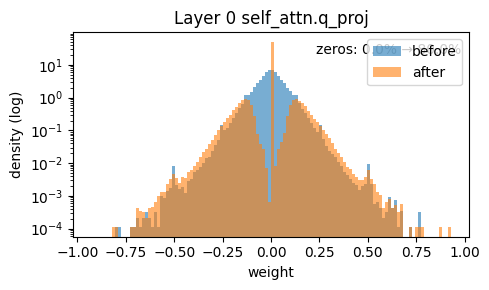

In [ ]:
# Visual: before/after weights for a pruned layer
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import OPTForCausalLM
from pathlib import Path

pruned_files = sorted(Path("pruned_models").glob("ppl_*.pt"))
if not pruned_files:
    raise FileNotFoundError("No pruned model found in ./pruned_models")

pruned_path = pruned_files[-1]

base_model = OPTForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype="auto", cache_dir=str(MODEL_PATH)
)
pruned_model = torch.load(pruned_path)

layer_idx = 0
layer_attr = "self_attn.q_proj"

base_layer = getattr(base_model.model.decoder.layers[layer_idx].self_attn, "q_proj")
pruned_layer = getattr(pruned_model.model.decoder.layers[layer_idx].self_attn, "q_proj")

base_w = base_layer.weight.detach().cpu().flatten().numpy()
pruned_w = pruned_layer.weight.detach().cpu().flatten().numpy()

zero_base = (base_w == 0).mean() * 100
zero_pruned = (pruned_w == 0).mean() * 100

max_abs = np.max(np.abs(np.concatenate([base_w, pruned_w])))

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(
    base_w, bins=120, range=(-max_abs, max_abs), density=True, alpha=0.6, label="before"
)
ax.hist(
    pruned_w,
    bins=120,
    range=(-max_abs, max_abs),
    density=True,
    alpha=0.6,
    label="after",
)
ax.set_yscale("log")
ax.set_title(f"Layer {layer_idx} {layer_attr}")
ax.set_xlabel("weight")
ax.set_ylabel("density (log)")
ax.legend()
ax.text(
    0.98,
    0.95,
    f"zeros: {zero_base:.1f}% → {zero_pruned:.1f}%",
    transform=ax.transAxes,
    ha="right",
    va="top",
)
plt.tight_layout()
plt.show()